In [47]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import prep_for_model_runs as prep
import model_params_class as mp
import run_models as run
import sys
import generate_matrix as inputs
sys.path.append('../')

In [48]:
import sys
!conda install --yes --prefix {sys.prefix} matplotlib

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.4
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Deterministic SIR model for multi-groups 
See: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4002176/


The model works like this: 
- Let's say we have N groups with size n_0 .... n_N
- Define four vectors (S = 'Susceptible, I = Infected, R = Recovered, D = Died) for each of the groups
    - for example: $\vec{I} = < I_0, I_1 \dots I_N >$ is the vector for the number of currently infected people in each subpopulation
- Assume a "contact matrix" $C = c_{ij} $ where $c_{ij}$ is the expected rate of contacts between groups i and j.
    - for example if $c_{i,j}$ = 0.1 that means that average number of contacts that an individual in group i has with group j is 0.1 --> i.e. there is a 1/10 chance they see anyone 
- Assume a "transmission matrix" $T = t_{ij}$ where $t_{ij}$  is the expected transmission between groups i and j if they make contact
    - The following code assumes that this is 1 (e.g. transmission rate is rolled into contact matrix) and is constant across groups. 
    - In a more sophisticated model, this assumption is not true. The transmission rate should not even be reciprocal. For example, if police are wearing masks when they interact with a community member, but there hands are equipment are dirty transmission rate could be higher in one direction. Transmission rate could also be higher for different types of interactions
- $\vec{\gamma}$ is the recovery rate .. e.g. $\gamma_i$ the likelihood that on a given day a sick person in group i recovers. We are using 1/14
- $\vec{\mu}$ is the death rate (divided by average disease duration) for each group

Combining contact and transmission, we can define a vector $\vec{\lambda}$ where $\lambda_i$ is the new infection rate (called the force of infection in the literature). 

- Force of infection = contact x transmission or $\lambda_i = \sum_j^N c_{ij} * t_{ij} $

Given $\vec{\lambda}$ the vector with contact rate * transmission rate, we can define our differential equations as follows:(Note that $t$ is current time and $t-1$ is previous time point. 

- Sub population totals : $\vec{N} = \vec{I_t} + \vec{R_t} + \vec{S_t} + \vec{D_t}$
- Susceptible number of people by sup-population: $\vec{S_t} = \vec{S_{t-1}} - \vec{I_{t-1}}$
- Infected by subpopulation $\vec{I_t} = \vec{I_{t-1}}+  \vec{\lambda} * \vec{S_{t-1}} * \frac{\vec{I_{t-1}}}{\vec{N}} - \vec{\gamma} \vec{I_{t-1}} - \vec{\mu} \vec{I_{t-1}}$ 
    - $\vec{I_t} =$ infected people before + newly infected people - infected people who recover
    - newly infected people = susceptible population * contact rate * transmission rate * proportion of population infected 
    - $\frac{\vec{I_{t-1}}}{\vec{N}}$ is the proportion of members of each group that are infected
- Recovered by Group: $\vec{R_t} = \vec{R_{t-1}} + \vec{\gamma} \vec{I_{t-1}}$

The implementation of this model does not try to count the number of individuals who have died, which simplifies it. 

In [51]:
def clean_df_names(df):
    df.columns = df.columns.str.strip()
    df.index = df.index.map(lambda s: s.strip())
    return df

In [226]:
"""Run multiple versions of the model, varying certain parameters to quantify uncertainty

params
------
base_dir: String
    the name of the directory where contact matrices and group size matrices are stored
    
starting_params: object of class ModelParams
    contains the initial parameters for the original model run
    
prison_peak_date: Int
    the day on which the prison infection rate peaks
    
days: Int
    the number of days to run the model for
    
returns
-------
monster_summary_stats: a DataFrame of all of the summary statistics for the model runs
infection_maps: a dictionary where the keys are stylized versions of a list of the starting parameters and the 
    values are infection_df's generated by these combinations of starting parameters
pd.concat(pop_sizes): a DataFrame that is a stacked version of all pop_size_df's output by the various model runs
"""
def run_models(policy_input_dirs, starting_params, prison_peak_date, days):
    monster_summary_stats = pd.DataFrame({})
    infection_maps = {}
    s_maps = {}
    pop_sizes = []
    pc = 10 #police contacts
    pgrp = 17 #police group size. Eventually should parametrize of have the dif. uncertainty
    prison_infection_rate = 0.35
    for policy_name, policy_input_path in policy_input_dirs.items():
        params = starting_params.add_uncertainty_params(prison_infection_rate, pc, pgrp)
        contact_data_post_sip = pd.read_csv(
            os.path.join(policy_input_path, inputs.CONTACT_MATRIX_POST_SIP)).set_index('Group_Name')
       
        contact_data_pre_SIP = clean_df_names(pd.read_csv(
            os.path.join(policy_input_path, inputs.CONTACT_MATRIX_PRE_SIP)).set_index('Group_Name'))

        group_size_data = pd.read_csv(os.path.join(policy_input_path, inputs.GROUP_SIZE_MATRIX), index_col = 0)
        
        if policy_name == inputs.LEVER_1_FOLDER:
            prison_lockdown_date = starting_params.sip_start_date + 7 #TODO: what should this actually be
            group_size_2 = pd.read_csv(os.path.join(policy_input_path, inputs.GROUP_SIZE_PRISON_MATRIX))
            print("prison_lockdown_date")
            summary, infection_df, s_df, pop_size_df = run.run_policy_intervention(policy_name,
                policy_input_path, starting_params, days,
                group_size_data, contact_data_pre_SIP,
                contact_data_post_sip, prison_peak_date, group_size_2, prison_lockdown_date)
        elif policy_name == inputs.LEVER_2_FOLDER:
               summary, infection_df, s_df, pop_size_df = run.run_policy_intervention(policy_name,
                policy_input_path, starting_params, days,
                group_size_data, contact_data_pre_SIP,
                contact_data_post_sip, prison_peak_date)    
        else: 
            summary, infection_df, s_df, pop_size_df = run.run_models(
                policy_input_path, starting_params, days, group_size_data,contact_data_pre_SIP,
                        contact_data_post_sip, prison_peak_date)                                             

        infection_maps[policy_name] = infection_df
        s_maps[policy_name] = s_df
        pop_sizes.append(pop_size_df)
        summary['Policy_Lever'] = policy_name        
        summary['Initial_Infections'] = starting_params.initial_infection_multiplier
        summary['Lockdown_Date'] = starting_params.sip_start_date
        summary['Prison_Rate'] = starting_params.prison_infection_rate
        summary['Police_Contact_Rate'] = 10
        summary['Police_Group_Size'] = 17 # Todo add to contact matrix code that we produce several of these. 
        #Then modify code accordingly
        monster_summary_stats= monster_summary_stats.append(summary)
        
    return monster_summary_stats, infection_maps, s_maps, pd.concat(pop_sizes)
    

In [278]:
#writing the matrices, we could return them so we wouldn't need to read them again 
INPUT_BASE_DIR = '../input2'

original_dir, lever_1_dir, lever_2_dir = inputs.write_all_matrices(INPUT_BASE_DIR)

resident hours --- white: 92.1702477472447, black: 92.744517984031
saving group size matrix to GROUP_SIZE.csv
5.4792118701645955e-06
5.714285714285714
12.857142857142858
12.857142857142858
white of black white police 0.7352216748768473 black: 0.26477832512315275
white --> police 6.895951865
 white --> police_contact 0.014371166754051723 + 0.005175545815948276 = 0.01954671257
72


/Users/rachelwarren/projects/CPE_Covid_Model/model/generate_matrix.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contact_matrix_pre_sip[g] = 0.0
/Users/rachelwarren/projects/CPE_Covid_Model/model/generate_matrix.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  white_at_home['hours_prop'] = white_at_home['Race_Home_Hours'] / white_at_home['Race_Home_Hours'].sum()
/Users/rachelwarren/projects/CPE_Covid_Model/model/generate_matrix.py:249: SettingWithCopyWarning: 
A value is trying to be set on a c

In [316]:
# Initial Input Parameters
PRISON_PEAK_DATE = 35
TRANSMISSION_RATE = 0.015
SIP_START_DATE  = 14
INITIAL_INFECTION_RATE =10

OUTPUT_DIR = 'output/'  #input2/CONTACT_MATRIX_POST_SIP.csv
CONTACT_MATRIX_PATH = 'CONTACT_MATRIX_POST_SIP.csv'
PRE_SOCIAL_DISTANCE_CONTACT_MATRIX = "CONTACT_MATRIX_PRE_SIP.csv"
GROUP_SIZE_PATH = 'GROUP_SIZE.csv'
DAYS = 120

In [317]:
starting_params = mp.ModelParams(TRANSMISSION_RATE, SIP_START_DATE, INITIAL_INFECTION_RATE)

summary_stats, infection_maps, s_maps, group_sizes = run_models({inputs.ORIGINAL_FOLDER: original_dir,
                                                                  inputs.LEVER_1_FOLDER : lever_1_dir,
                                                                  inputs.LEVER_2_FOLDER: lever_2_dir},
                                                                  starting_params, PRISON_PEAK_DATE, DAYS)

policy_lever_1
policy_lever_2


In [322]:
summary_stats.to_csv(os.path.join(OUTPUT_DIR, 'full_summary_stats.csv'))

In [300]:
summary_stats[summary_stats['Policy_Lever'] == 'lever1'][['model_name', 'cumulative_infected_40_days']]

,model_name,cumulative_infected_40_days
Black,original,55557.0
Black_Forced_Labour,original,34687.0
White,original,45649.0
White_Forced_Labour,original,106204.0
Total_Residents,original,242097.0
Total_w_Police,original,244329.0


In [318]:
summary_stats[summary_stats['Policy_Lever'] == 'lever2'][['model_name', 'cumulative_infected_40_days']]

,model_name,cumulative_infected_40_days
Black,original,54971.0
Black_Forced_Labour,original,34492.0
White,original,44566.0
White_Forced_Labour,original,105647.0
Total_Residents,original,239675.0
Total_w_Police,original,241893.0


In [320]:
summary_stats[summary_stats['Policy_Lever'] == 'no_policy'][['model_name', 'cumulative_infected_40_days']]

,model_name,cumulative_infected_40_days
Black,original,62062.0
Black_Forced_Labour,original,39425.0
White,original,50829.0
White_Forced_Labour,original,121713.0
Total_Residents,original,274029.0
Total_w_Police,original,276654.0
Black,no_police,61186.0
Black_Forced_Labour,no_police,39090.0
White,no_police,48267.0
White_Forced_Labour,no_police,120611.0


In [286]:
summary_stats[summary_stats['Policy_Lever'] == 'no_policy'].loc[['White']][['model_name', 'cumulative_infected_40_days']]

,model_name,cumulative_infected_40_days
White,original,50829.0
White,no_police,48267.0
White,no_prison,49790.0
White,no_prison_or_police,47235.0
White,no_forced_labour,14022.0
White,no_police_prison_fl,10830.0


In [303]:
infection_no_policy = infection_maps['no_policy']

In [304]:
infection_no_policy

,Black,Black_Forced_Labour,Black_Police,Black_Prison,White,White_Forced_Labour,White_Police,White_Prison,Day,Total_Residents,Total_w_Police,model_name,Policy_Lever,name
0,42.285517,10.000000,0.199706,0.000000,208.220461,37.231245,0.555477,0.000000,0,297.737223,298.492406,original,no_policy,I10_PI0.35_L14___pc10_pgrp17
1,50.454465,13.171583,0.275375,1.000000,248.414309,49.033841,0.765889,1.000000,1,361.074199,362.115463,original,no_policy,I10_PI0.35_L14___pc10_pgrp17
2,61.072602,17.235547,0.373277,1.276931,297.671826,63.623091,1.028607,1.281101,2,439.603066,441.004949,original,no_policy,I10_PI0.35_L14___pc10_pgrp17
3,74.718649,22.403569,0.499237,1.630553,358.086538,81.651895,1.356864,1.641220,3,536.860651,538.716751,original,no_policy,I10_PI0.35_L14___pc10_pgrp17
4,92.123947,28.941433,0.660537,2.082105,432.269252,103.932743,1.767154,2.102570,4,657.267375,659.695067,original,no_policy,I10_PI0.35_L14___pc10_pgrp17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,1186.549479,0.000000,0.879981,5198.322864,65191.145199,0.000000,21.682558,5826.677136,116,66377.694678,66400.257217,no_police_prison_fl,no_policy,I10_PI0.35_L14___pc10_pgrp17
117,1176.751413,0.000000,0.874773,5198.322864,66488.497301,0.000000,21.949583,5826.677136,117,67665.248714,67688.073070,no_police_prison_fl,no_policy,I10_PI0.35_L14___pc10_pgrp17
118,1170.728448,0.000000,0.872095,5198.322864,67797.591856,0.000000,22.237748,5826.677136,118,68968.320304,68991.430147,no_police_prison_fl,no_policy,I10_PI0.35_L14___pc10_pgrp17
119,1167.889559,0.000000,0.871551,5198.322864,69118.039638,0.000000,22.543952,5826.677136,119,70285.929197,70309.344700,no_police_prison_fl,no_policy,I10_PI0.35_L14___pc10_pgrp17


In [305]:
p = group_sizes.loc['no_policy_original']

Group_Name
Black                                 771744.512940
Black_Forced_Labour                   182508.000000
Black_Police                            3644.800000
Black_Prison                           14852.351039
White                                3800189.998699
White_Forced_Labour                   679500.000000
White_Police                           10137.898400
White_Prison                           16647.648961
Total_Residents                      5433942.511639
Total_w_Police                       5447725.210039
name                   I10_PI0.35_L14___pc10_pgrp17
Name: no_policy_original, dtype: object

In [307]:
infection_no_policy

,Black,Black_Forced_Labour,Black_Police,Black_Prison,White,White_Forced_Labour,White_Police,White_Prison,Day,Total_Residents,Total_w_Police,model_name,Policy_Lever,name
0,42.285517,10.000000,0.199706,0.000000,208.220461,37.231245,0.555477,0.000000,0,297.737223,298.492406,original,no_policy,I10_PI0.35_L14___pc10_pgrp17
1,50.454465,13.171583,0.275375,1.000000,248.414309,49.033841,0.765889,1.000000,1,361.074199,362.115463,original,no_policy,I10_PI0.35_L14___pc10_pgrp17
2,61.072602,17.235547,0.373277,1.276931,297.671826,63.623091,1.028607,1.281101,2,439.603066,441.004949,original,no_policy,I10_PI0.35_L14___pc10_pgrp17
3,74.718649,22.403569,0.499237,1.630553,358.086538,81.651895,1.356864,1.641220,3,536.860651,538.716751,original,no_policy,I10_PI0.35_L14___pc10_pgrp17
4,92.123947,28.941433,0.660537,2.082105,432.269252,103.932743,1.767154,2.102570,4,657.267375,659.695067,original,no_policy,I10_PI0.35_L14___pc10_pgrp17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,1186.549479,0.000000,0.879981,5198.322864,65191.145199,0.000000,21.682558,5826.677136,116,66377.694678,66400.257217,no_police_prison_fl,no_policy,I10_PI0.35_L14___pc10_pgrp17
117,1176.751413,0.000000,0.874773,5198.322864,66488.497301,0.000000,21.949583,5826.677136,117,67665.248714,67688.073070,no_police_prison_fl,no_policy,I10_PI0.35_L14___pc10_pgrp17
118,1170.728448,0.000000,0.872095,5198.322864,67797.591856,0.000000,22.237748,5826.677136,118,68968.320304,68991.430147,no_police_prison_fl,no_policy,I10_PI0.35_L14___pc10_pgrp17
119,1167.889559,0.000000,0.871551,5198.322864,69118.039638,0.000000,22.543952,5826.677136,119,70285.929197,70309.344700,no_police_prison_fl,no_policy,I10_PI0.35_L14___pc10_pgrp17


In [308]:
# Look at the infection rates for just one racial group
infection_no_policy[infection_no_policy['model_name'].isin(['original', 'no_police']) & (infection_no_policy['Day'] == 30)]

,Black,Black_Forced_Labour,Black_Police,Black_Prison,White,White_Forced_Labour,White_Police,White_Prison,Day,Total_Residents,Total_w_Police,model_name,Policy_Lever,name
30,10507.408033,7136.990433,157.082645,1199.107505,11197.762692,22037.010197,316.146425,1318.014594,30,50879.171356,51352.400426,original,no_policy,I10_PI0.35_L14___pc10_pgrp17
30,10376.601692,7085.292756,156.055583,1199.107505,10807.261201,21872.325049,313.766495,1318.014594,30,50141.480698,50611.302776,no_police,no_policy,I10_PI0.35_L14___pc10_pgrp17


In [309]:
np.round(s_maps['no_policy'][infection_no_policy['model_name'].isin(['original'])]['Black'])[0:10]

0    771702.0
1    771694.0
2    771683.0
3    771670.0
4    771652.0
5    771630.0
6    771602.0
7    771567.0
8    771523.0
9    771468.0
Name: Black, dtype: float64

In [310]:
infection_no_policy[infection_no_policy['model_name'].isin(['original'])]['Black']

0       42.285517
1       50.454465
2       61.072602
3       74.718649
4       92.123947
          ...    
116    983.522234
117    944.836056
118    908.464581
119    874.200565
120    841.870007
Name: Black, Length: 121, dtype: float64

original
10507.408033489994
original
7136.990432937274
original
50879.17135594027
no_police
10376.601691864627
no_police
7085.292755614553
no_police
50141.480697628984
original
11197.762692257202
original
22037.010197255804
no_police
10807.261200785302
no_police
21872.3250493645


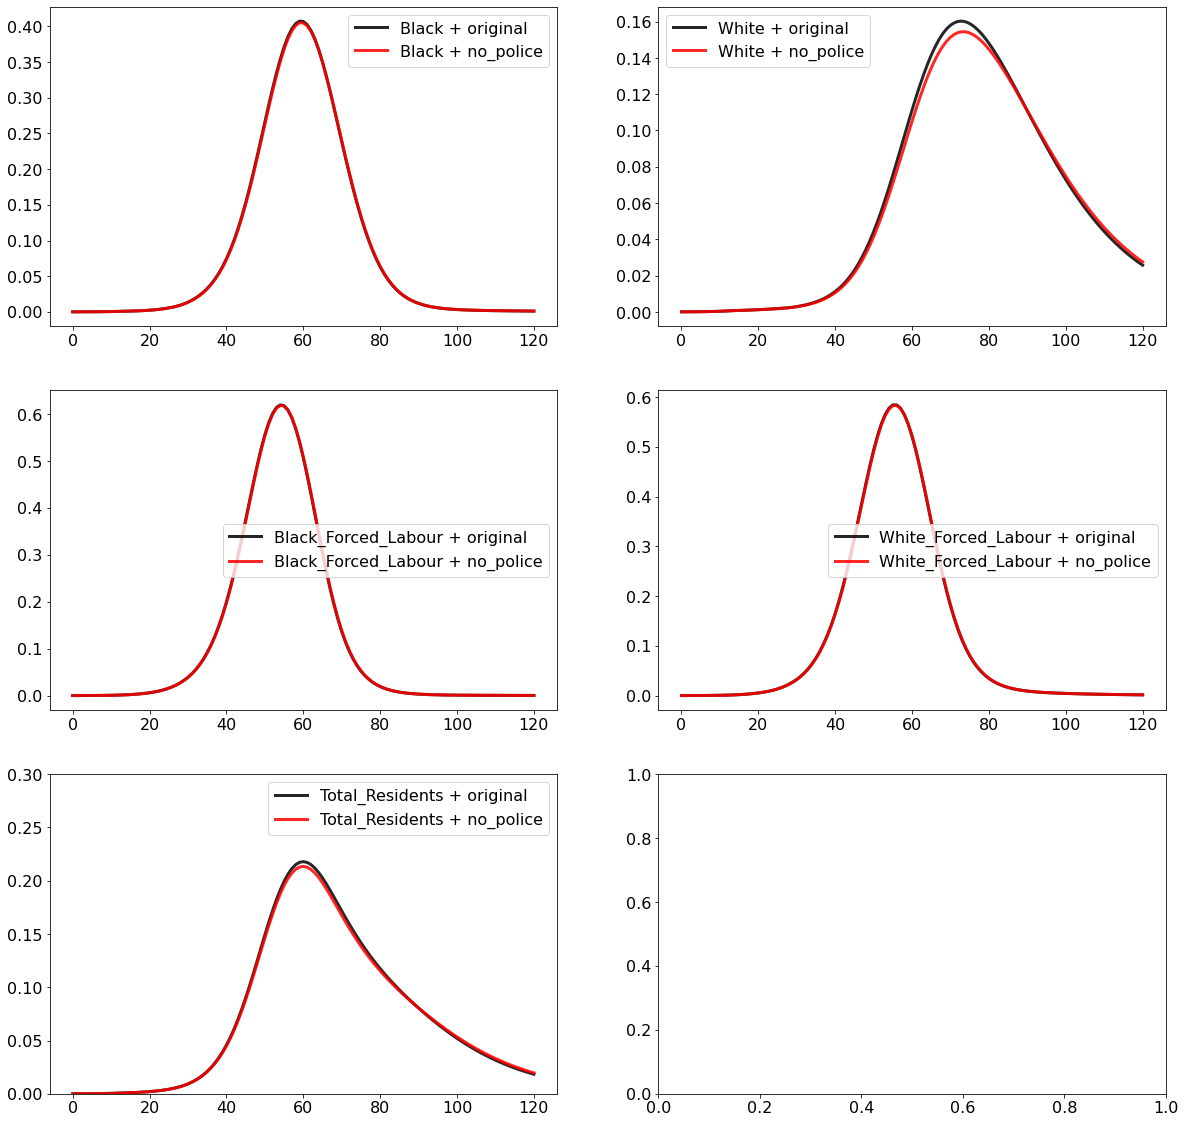

In [311]:
model_colors = {
    'original' : 'k',
   # 'eq_forced_labour': 'p',
  #  'no_prison': 'b',
    'no_police': 'g'
   # 'no_prison_or_police': 'r'
#     'no_forced_labour' : 'orange'
}

def plot_infection_number_seperate_race(ax,i,infections_df, group_size, groups, color_column, color_key):
    for k, v in color_key.items():
        df = infections_df[infections_df[color_column] == k]
        for j in range(0, len(groups)):
            group = groups[j]
            print(k)
            print(df[group].iloc[30])
            label_name = f'{group} + {k}'
            ax[j,i].plot(df['Day'].values, df[group]/group_size[group], v, alpha=0.85, lw=3, label = label_name)
            ax[j,i].legend()
            #ax[j,i].set_xlim(30, 50)
            
        
    
fig, ax  = plt.subplots(3, 2, figsize = (20, 20))

plot_infection_number_seperate_race(ax, 0, infection_maps['no_policy'], p, ['Black', 'Black_Forced_Labour', 'Total_Residents'], 'model_name', {
    'original' : 'k',
    'no_police': 'r'} )
plot_infection_number_seperate_race(ax, 1, infection_maps['no_policy'], p, ['White', 'White_Forced_Labour'], 'model_name', {
    'original' : 'k',
    'no_police': 'r'} )
ax[2,0].set_ylim(0,0.3)
plt.show()


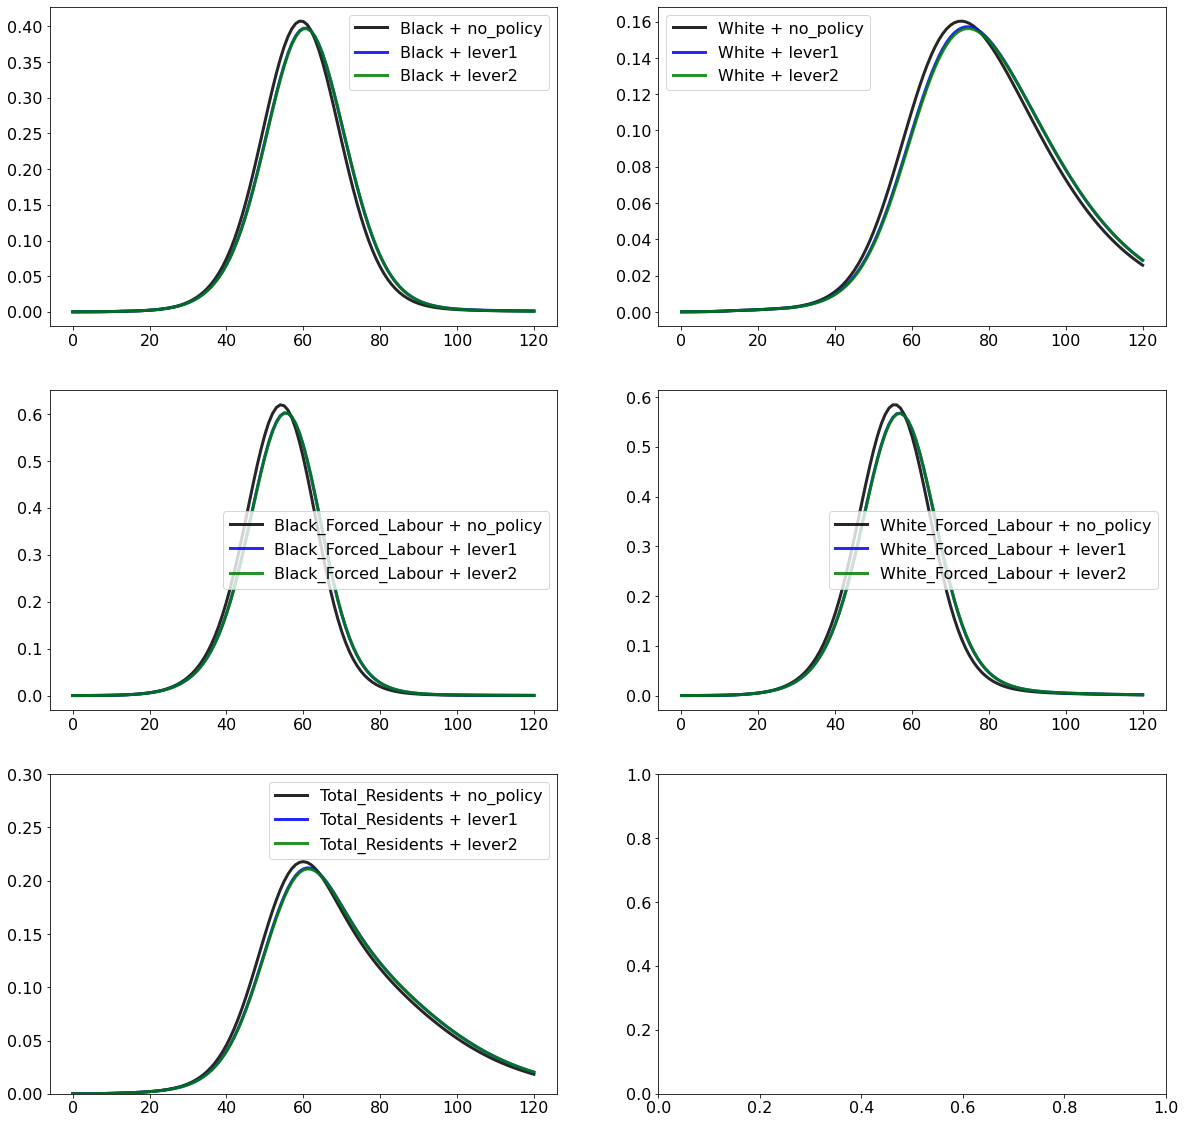

In [312]:
def plot_infection_number_seperate_race(ax,i,infections_df, group_size, groups, color_column, color_key):
    for k, v in color_key.items():
        df = infections_df[infections_df[color_column] == k]
        for j in range(0, len(groups)):
            group = groups[j]
            label_name = f'{group} + {k}'
            ax[j,i].plot(df['Day'].values, df[group]/group_size[group], v, alpha=0.85, lw=3, label = label_name)
            ax[j,i].legend()
            #ax[j,i].set_xlim(30, 50)
            
        
    
fig, ax  = plt.subplots(3, 2, figsize = (20, 20))


plot_infection_number_seperate_race(ax, 0, infection_no_policy[infection_no_policy['model_name'] == 'original'],
                                    p, ['Black', 'Black_Forced_Labour', 'Total_Residents'], 'Policy_Lever', {
    'no_policy' : 'k'} )
plot_infection_number_seperate_race(ax, 0, infection_maps['lever1'],
                                    p, ['Black', 'Black_Forced_Labour', 'Total_Residents'], 'Policy_Lever', {'lever1' : 'b'} )

plot_infection_number_seperate_race(ax, 0, infection_maps['lever2'], p, ['Black', 'Black_Forced_Labour', 'Total_Residents'], 'Policy_Lever', {'lever2' : 'g'})


plot_infection_number_seperate_race(ax, 1, infection_no_policy[infection_no_policy['model_name'] == 'original'],
                                    p, ['White', 'White_Forced_Labour'], 'Policy_Lever', {
    'no_policy' : 'k'} )
plot_infection_number_seperate_race(ax, 1, infection_maps['lever1'],
                                    p, ['White', 'White_Forced_Labour'], 'Policy_Lever', {'lever1' : 'b'} )

plot_infection_number_seperate_race(ax, 1, infection_maps['lever2'], p, ['White', 'White_Forced_Labour'], 'Policy_Lever', {'lever2' : 'g'} )
ax[2,0].set_ylim(0,0.3)
ax[2,0].set_ylim(0,0.3)
plt.show()

In [313]:
# Make Some Plots to Visualize The Infection In the Synthetic City

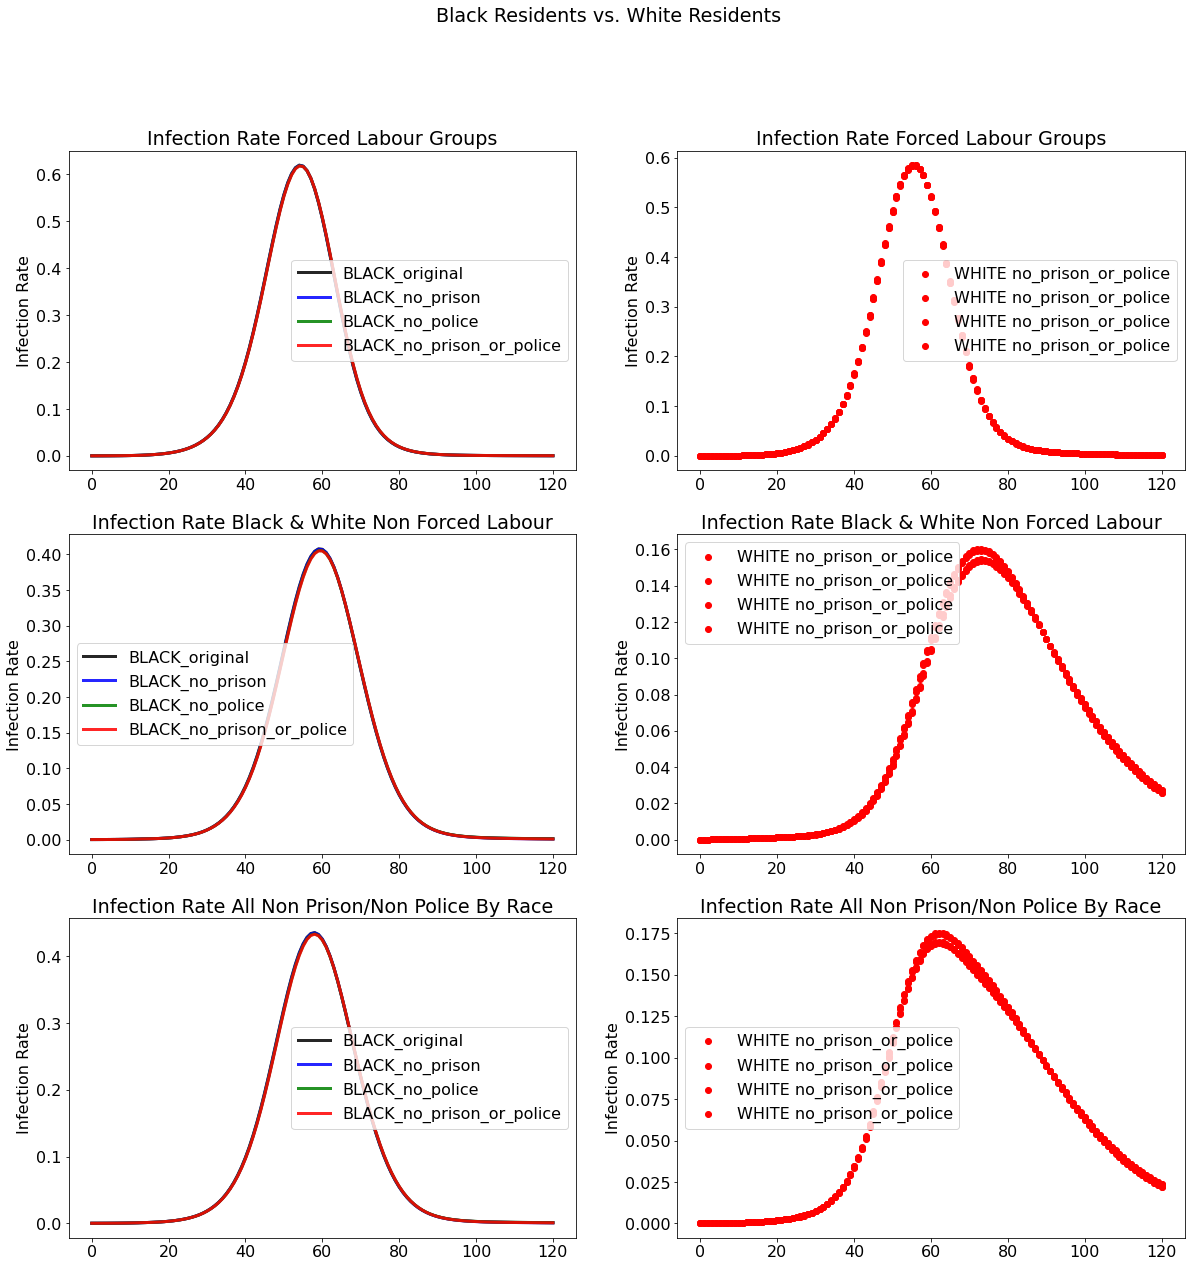

In [207]:
fig, ax  = plt.subplots(3, 2, figsize = (20, 20))
fig.suptitle("Black Residents vs. White Residents")

model_colors = {
    'original' : 'k',
   # 'eq_forced_labour': 'p',
    'no_prison': 'b',
    'no_police': 'g',
    'no_prison_or_police': 'r'
#     'no_forced_labour' : 'orange'
}

for model_name in model_colors.keys():
    df = infection_no_policy[infection_no_policy['model_name'] == model_name].set_index('Day')
    pop_size = group_sizes.loc['no_policy_original']
    #print(k + "   " + str(pop_size['Black_Forced_Labour']))
    x = df['Black_Forced_Labour']/pop_size['Black_Forced_Labour']
    y = df['Black']/pop_size['Black']
    z = (df['Black'] + df['Black_Forced_Labour'])/ (pop_size['Black'] + pop_size['Black_Forced_Labour'])

    ax[0, 0].plot(df.index, x , model_colors[model_name], alpha=0.85, lw=3, label = 'BLACK_' + model_name)
    ax[1,0].plot(df.index, y ,model_colors[model_name], alpha=0.85, lw=3, label='BLACK_' + model_name)
    ax[2,0].plot(df.index, z, model_colors[model_name], alpha =0.85, lw=3, label =  "BLACK_" + model_name)

    #if k in ['original', 'no_forced_labour']:
    z2 = (df['White'] + df['White_Forced_Labour'])/(pop_size['White'] + pop_size['White_Forced_Labour'])

    ax[0,1].scatter(
        df.index, df['White_Forced_Labour']/pop_size['White_Forced_Labour'],
                color = model_colors[k], lw = 1, label = 'WHITE '+k)
    ax[1,1].scatter(df.index, df['White']/pop_size['White'], color = model_colors[k], lw = 1, label = 'WHITE '+ k)
    ax[2,1].scatter(df.index, z2, color = model_colors[k], lw = 1, label = 'WHITE '+k)
    
for r in range(0, 3):
    for c in range(0,2):
        ax[r,c].set_ylabel('Infection Rate')
        ax[r,c].legend(loc = 'best')
       # ax[r,c].set_xlim(10, 100)
        ax[0,c].set_title('Infection Rate Forced Labour Groups')
        ax[1,c].set_title('Infection Rate Black & White Non Forced Labour')
        ax[2,c].set_title('Infection Rate All Non Prison/Non Police By Race')
      #  ax[2,c].set_ylim(0, 0.2)
        

plt.show()

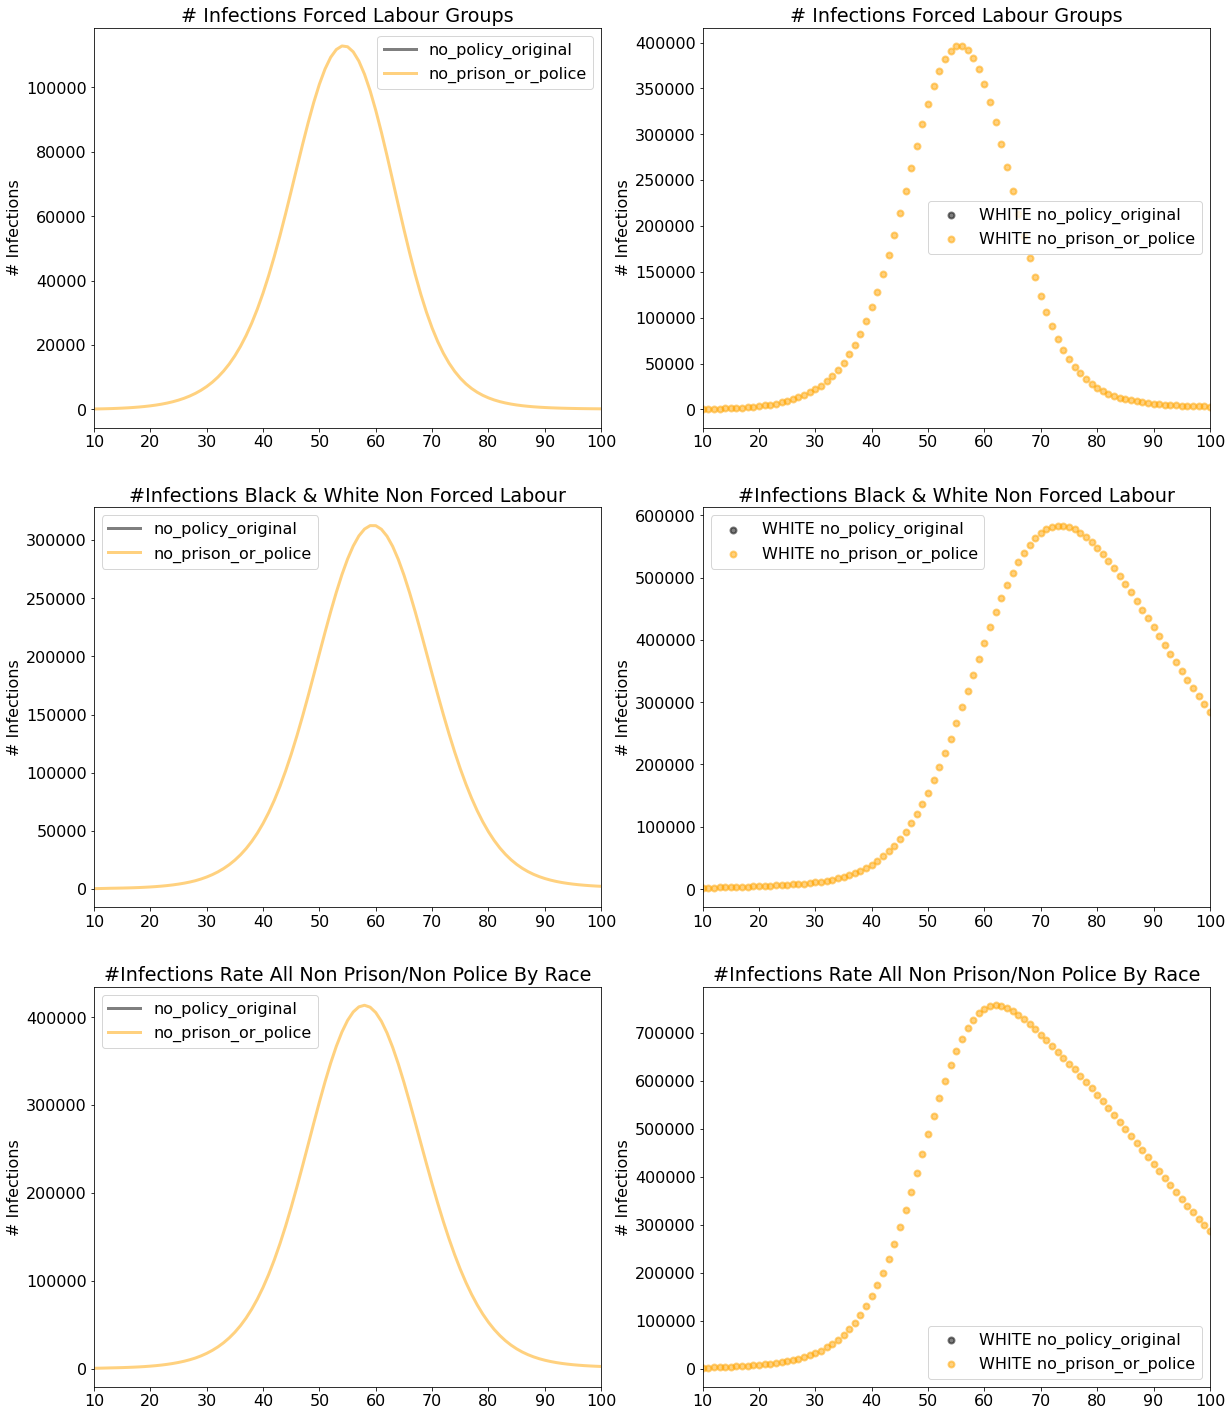

In [208]:
fig, ax = plt.subplots(3,2, figsize = (20, 25))
#fig.suptitle("Black Residents vs. White Residents")
plt.rc('font', size=16) 

model_colors = {
    'no_policy_original' : 'k',
    'no_prison_or_police' : 'orange'
}
for k in model_colors.keys():
    df = infection_no_policy[infection_no_policy['model_name'] == k]
    pop_size = group_sizes.loc[k]
    
    x = df['Black_Forced_Labour']
    y= df['Black']
    z = (df['Black'] + df['Black_Forced_Labour'])

    x2 = df['White_Forced_Labour']
    y2 = df['White'] 
    z2 = (df['White'] + df['White_Forced_Labour'])

    #/(pop_size['White'] + pop_size['White_Forced_Labour'])

    ax[0,0].plot(df.index, x , model_colors[k], alpha=0.5, lw=3, label=k+'')
    ax[1,0].plot(df.index, y ,model_colors[k], alpha=0.5, lw=3, label=k+'')
    ax[2,0].plot(df.index, z, model_colors[k], alpha = 0.5, lw = 3, label = k)

    #if k in ['original', 'eq_police_prison_fl']:
    ax[0,1].scatter(df.index, x2 , color = model_colors[k], alpha=0.5, lw=2, label='WHITE ' + k)
    ax[1,1].scatter(df.index, y2 ,color = model_colors[k], alpha=0.5, lw=2, label='WHITE ' + k)
    ax[2,1].scatter(df.index, z2, color = model_colors[k], alpha = 0.5, lw = 2, label ='WHITE ' + k)

for r in range(0, 3):
    for c in range(0,2):
        ax[r,c].set_ylabel('# Infections')
        ax[r,c].legend(loc = 'best')
        ax[r,c].set_xlim(10, 100)
        ax[0,c].set_title('# Infections Forced Labour Groups')
        ax[1,c].set_title('#Infections Black & White Non Forced Labour')
        ax[2,c].set_title('#Infections Rate All Non Prison/Non Police By Race')    

plt.show()